In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'/opt/spark'

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setAppName('test_app').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

21/10/16 19:22:45 WARN Utils: Your hostname, vhdinh-asus resolves to a loopback address: 127.0.1.1; using 192.168.0.103 instead (on interface wlp4s0)
21/10/16 19:22:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/10/16 19:22:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/10/16 19:22:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Read the data

In [3]:
df = spark.read.parquet("Bonn_SummaryFile.parquet")

In [4]:
df.show(5)

21/10/16 19:22:52 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------------+---------------------+-----------------------+-------------+-----------------+--------------------+---------------+-------------------+-------------+-----------+-----------------+------------+------------------+-----------------+------------+---------+--------------+--------------+-----------+-------------------+---------------------+-----------------------------+----------+--------------------+-----------------+------------------+---------------+----------------------+-----------------------+-------------------------+------------------------------+---------------------+-----------------+------------------------+--------------------+----------------+----------------+----------------------+---------------+--------------------------+----------------+--------------------+------------------------+---------------------+---------------+-------------+
|           gmlid|building_parent_gmlid|Building_footprint_area|    roof_type|building_function|storeys_above_ground|measured

In [5]:
df.printSchema()

root
 |-- gmlid: string (nullable = true)
 |-- building_parent_gmlid: string (nullable = true)
 |-- Building_footprint_area: double (nullable = true)
 |-- roof_type: string (nullable = true)
 |-- building_function: string (nullable = true)
 |-- storeys_above_ground: decimal(8,0) (nullable = true)
 |-- measured_height: double (nullable = true)
 |-- building_attachment: boolean (nullable = true)
 |-- building_type: string (nullable = true)
 |-- family_home: string (nullable = true)
 |-- gross_floor_space: float (nullable = true)
 |-- living_space: float (nullable = true)
 |-- calculated_storeys: integer (nullable = true)
 |-- storeys_predicted: integer (nullable = true)
 |-- bldg_storeys: integer (nullable = true)
 |-- flat_roof: integer (nullable = true)
 |-- flatRoof_ratio: float (nullable = true)
 |-- roofPitch_mean: float (nullable = true)
 |-- garage_type: string (nullable = true)
 |-- garage_parking_lots: float (nullable = true)
 |-- garage_type_predicted: string (nullable = true)


In [6]:
df.count()

229521

In [7]:
print(len(df.columns))

46


In [8]:
df.select('building_function').distinct().collect()

[Row(building_function='Gebäude zur Elektrizitätsversorgung'),
 Row(building_function='Betriebsgebäude für Schienenverkehr'),
 Row(building_function='Kegel-, Bowlinghalle'),
 Row(building_function='Lagerhalle, Lagerschuppen, Lagerhaus'),
 Row(building_function='Hochschulgebäude (Fachhochschule, Universität)'),
 Row(building_function='Sport-, Turnhalle'),
 Row(building_function='Funkmast'),
 Row(building_function='Kreditinstitut'),
 Row(building_function='Aquarium, Terrarium, Voliere'),
 Row(building_function='Festsaal'),
 Row(building_function='Kinderkrippe, Kindergarten, Kindertagesstätte'),
 Row(building_function='Pumpstation'),
 Row(building_function='Heilanstalt, Pflegeanstalt, Pflegestation'),
 Row(building_function='Müllbunker'),
 Row(building_function='Gebäude zum Parken'),
 Row(building_function='Polizei'),
 Row(building_function='Gebäude für Forschungszwecke'),
 Row(building_function='Fabrik'),
 Row(building_function='Land- und forstwirtschaftliches Wohngebäude'),
 Row(buildin

In [9]:
print(len(df.select('building_function').distinct().collect()))

193


#### Drop duplicates

In [10]:
n1 = df.count()
print("number of rows: ", n1)
n2 = df.dropDuplicates().count()
print("number of rows after dropping duplicates: ", n2)

number of rows:  229521


number of rows after dropping duplicates:  229521


There is no duplicated data.

# Feature selection and Handling missing data

In [11]:
df_sub = df.select(['building_function','storeys_above_ground','family_home','living_space',
                   'calculated_storeys','garage_parking_lots','solar_area','longitude',
                   'latitude','alkis_construction_year','alkis_parcel_area',
                   'alkis_floor_area','alkis_attic_conversion','municipality_key',
                   'dormer_number','converted_attic'])

In [12]:
len(df_sub.columns)

16

In [13]:
df_sub.printSchema()

root
 |-- building_function: string (nullable = true)
 |-- storeys_above_ground: decimal(8,0) (nullable = true)
 |-- family_home: string (nullable = true)
 |-- living_space: float (nullable = true)
 |-- calculated_storeys: integer (nullable = true)
 |-- garage_parking_lots: float (nullable = true)
 |-- solar_area: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- alkis_construction_year: integer (nullable = true)
 |-- alkis_parcel_area: double (nullable = true)
 |-- alkis_floor_area: double (nullable = true)
 |-- alkis_attic_conversion: integer (nullable = true)
 |-- municipality_key: string (nullable = true)
 |-- dormer_number: double (nullable = true)
 |-- converted_attic: integer (nullable = true)



In [14]:
df_sub.select(['building_function','living_space']).toPandas()

,building_function,living_space
0,Kapelle,0.0
1,Kirche,0.0
2,Tiefgarage,0.0
3,Umformer,0.0
4,Umformer,0.0
...,...,...
229516,None,0.0
229517,None,0.0
229518,None,0.0
229519,None,0.0


In [15]:
living_space = df_sub.select(['building_function','living_space']).toPandas()
living_space[living_space['living_space'] != 0]

,building_function,living_space
13,Wohnhaus,177.339996
20,Wohngebäude mit Gemeinbedarf,484.269989
22,Wohngebäude mit Gemeinbedarf,279.820007
27,Wohngebäude mit Gemeinbedarf,308.579987
28,Wohnhaus,389.359985
...,...,...
164713,Wohnhaus,245.500000
164715,Wohnhaus,31.780001
164716,Wohnhaus,171.179993
164718,Wohnhaus,179.389999


In [16]:
living_space[living_space['living_space'] != 0].count()

building_function    83407
living_space         83407
dtype: int64

In [17]:
living_space['building_function'].unique()

array(['Kapelle', 'Kirche', 'Tiefgarage', 'Umformer',
       'Kinderkrippe, Kindergarten, Kindertagesstätte', 'Wohnhaus',
       'Sport-, Turnhalle', 'Hotel, Motel, Pension',
       'Allgemein bildende Schule', 'Bibliothek, Bücherei',
       'Nach Quellenlage nicht zu spezifizieren',
       'Gebäude für soziale Zwecke', 'Wohngebäude mit Gemeinbedarf',
       'Gebäude für Wirtschaft oder Gewerbe', 'Garage',
       'Gebäude für öffentliche Zwecke', 'Bürogebäude',
       'Wohngebäude mit Handel und Dienstleistungen',
       'Gebäude für Handel und Dienstleistungen',
       'Lagerhalle, Lagerschuppen, Lagerhaus', 'Geschäftsgebäude',
       'Wohnheim', 'Gebäude für Gewerbe und Industrie mit Wohnen',
       'Verwaltungsgebäude', 'Werkstatt', 'Schuppen',
       'Gemischt genutztes Gebäude mit Wohnen', 'Wohngebäude',
       'Forsthaus', 'Überdachung', 'Carport',
       'Gebäude für Bildung und Forschung', 'Pumpstation', 'Tankstelle',
       'Wohngebäude mit Gewerbe und Industrie', 'Stall',
   

In [18]:
len(living_space['building_function'].unique())

193

In [19]:
living_space[living_space['living_space'].notna()].count()

building_function    164723
living_space         229521
dtype: int64

living_space does not have any null values, only >= 0. Building_function has null values

In [20]:
living_space[living_space['building_function'].notna()].count()

building_function    164723
living_space         164723
dtype: int64

In [21]:
(229521-164723)/229521

0.28231839352390414

The null data in building_function is 28%.

In [22]:
residence_types = ['Studenten-, Schülerwohnheim',
    'Land- und forstwirtschaftliches Wohngebäude',
    'Wohngebäude mit Gewerbe und Industrie',
    'Wohn- und Geschäftsgebäude',
    'Wohn- und Verwaltungsgebäude',
    'Wohngebäude',
    'Gartenhaus',
    'Forsthaus',
    'Bauernhaus',
    'Wohn- und Bürogebäude',
    'Land- und forstwirtschaftliches Wohn- und Betriebsgebäude',
    'Scheune',
    'Wohnhaus',
    'Gebäude für Handel und Dienstleistung mit Wohnen',
    'Schwesternwohnheim',
    'Wohn- und Wirtschaftsgebäude',
    'Gemischt genutztes Gebäude mit Wohnen',
    'Wohngebäude mit Gemeinbedarf',
    'Gebäude für öffentliche Zwecke mit Wohnen',
    'Speichergebäude',
    'Wohngebäude mit Handel und Dienstleistungen',
    'Gebäude für Gewerbe und Industrie mit Wohnen',
    'Wohnheim']

In [23]:
df_resi = df.filter(df['building_function'].isin(residence_types))

In [24]:
print(type(df_resi))

<class 'pyspark.sql.dataframe.DataFrame'>


In [25]:
df_resi.toPandas().head(5)

,gmlid,building_parent_gmlid,Building_footprint_area,roof_type,building_function,storeys_above_ground,measured_height,building_attachment,building_type,family_home,...,alkis_roof_shape,alkis_attic_conversion,alkis_high_rise,alkis_storeys_under_ground,municipality_key,terrain_intersection,footprint_geometry_wgs84,parcel_geometry_wgs84,converted_attic,dormer_number
0,DENW36AL100000jS,None,221.668,None,Wohnhaus,None,NaN,False,Ein-/Mehrfamilienhaus,Single,...,None,NaN,None,NaN,05314000,None,"POLYGON((7.17270282093791 50.6866554172958,7.1...","POLYGON((7.17248913775734 50.6866085360044,7.1...",1.0,9.0
1,DENW36AL10000D64,None,121.062,Mixed Form,Wohngebäude mit Gemeinbedarf,None,15.570,True,Reihenhaus (Ecke),Multi,...,None,NaN,None,NaN,05314000,MULTILINESTRING Z ((370723.453 5616128.973 62....,"POLYGON((7.17004216777208 50.6826468031706,7.1...","POLYGON((7.17022762940047 50.6826879125655,7.1...",1.0,7.0
2,DENW36AL10000D66,None,87.444,Mixed Form,Wohngebäude mit Gemeinbedarf,None,15.113,True,Reihenhaus (Ecke),Single,...,None,NaN,None,NaN,05314000,MULTILINESTRING Z ((370759.864 5616054.224 63....,"POLYGON((7.17042608123161 50.6819405062288,7.1...","POLYGON((7.17003766486546 50.6818204994941,7.1...",1.0,4.0
3,DENW36AL10000D6A,None,96.433,Saddle Roof,Wohngebäude mit Gemeinbedarf,None,14.728,True,Reihenhaus,Single,...,None,NaN,None,NaN,05314000,MULTILINESTRING Z ((370749.638 5616350.364 63....,"POLYGON((7.17037314769085 50.6845710628155,7.1...","POLYGON((7.17037314769085 50.6845710628155,7.1...",1.0,4.0
4,DENW36AL10000D6b,None,121.674,Saddle Roof,Wohnhaus,None,13.713,False,Ein-/Mehrfamilienhaus,Single,...,None,NaN,None,NaN,05314000,MULTILINESTRING Z ((370475.154 5616021.54 60.3...,"POLYGON((7.16662755208015 50.6816170944647,7.1...","POLYGON((7.16681865256589 50.6814922707109,7.1...",1.0,6.0


In [26]:
df_resi.count()

84668

In [27]:
df_resi_sub = df_resi.select(['building_function','storeys_above_ground','family_home','living_space',
                   'calculated_storeys','garage_parking_lots','solar_area','longitude',
                   'latitude','alkis_construction_year','alkis_parcel_area',
                   'alkis_floor_area','alkis_attic_conversion','municipality_key',
                   'dormer_number','converted_attic'])

In [28]:
len(df_resi_sub.columns)

16

In [29]:
df_resi_sub.printSchema()

root
 |-- building_function: string (nullable = true)
 |-- storeys_above_ground: decimal(8,0) (nullable = true)
 |-- family_home: string (nullable = true)
 |-- living_space: float (nullable = true)
 |-- calculated_storeys: integer (nullable = true)
 |-- garage_parking_lots: float (nullable = true)
 |-- solar_area: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- alkis_construction_year: integer (nullable = true)
 |-- alkis_parcel_area: double (nullable = true)
 |-- alkis_floor_area: double (nullable = true)
 |-- alkis_attic_conversion: integer (nullable = true)
 |-- municipality_key: string (nullable = true)
 |-- dormer_number: double (nullable = true)
 |-- converted_attic: integer (nullable = true)



In [30]:
df_resi_sub.where(df_resi_sub['living_space'] != 0).count()

83403

-> Should delete rows with 0 living space.

In [31]:
df_resi_sub = df_resi_sub.where(df_resi_sub['living_space'] != 0)
df_resi_sub.count()

83403

In [32]:
df_resi_sub.toPandas().head()

,building_function,storeys_above_ground,family_home,living_space,calculated_storeys,garage_parking_lots,solar_area,longitude,latitude,alkis_construction_year,alkis_parcel_area,alkis_floor_area,alkis_attic_conversion,municipality_key,dormer_number,converted_attic
0,Wohnhaus,None,Single,177.339996,4.0,NaN,NaN,7.172823,50.686604,NaN,352.0,NaN,NaN,05314000,9.0,1.0
1,Wohngebäude mit Gemeinbedarf,None,Multi,484.269989,5.0,NaN,0.0,7.170154,50.682630,NaN,403.0,NaN,NaN,05314000,7.0,1.0
2,Wohngebäude mit Gemeinbedarf,None,Single,279.820007,4.0,NaN,0.0,7.170523,50.681933,NaN,526.0,NaN,NaN,05314000,4.0,1.0
3,Wohngebäude mit Gemeinbedarf,None,Single,308.579987,4.0,NaN,0.0,7.170401,50.684632,NaN,195.0,NaN,NaN,05314000,4.0,1.0
4,Wohnhaus,None,Single,389.359985,4.0,NaN,0.0,7.166636,50.681545,NaN,713.0,NaN,NaN,05314000,6.0,1.0


In [33]:
df_resi_sub.distinct().toPandas()

,building_function,storeys_above_ground,family_home,living_space,calculated_storeys,garage_parking_lots,solar_area,longitude,latitude,alkis_construction_year,alkis_parcel_area,alkis_floor_area,alkis_attic_conversion,municipality_key,dormer_number,converted_attic
0,Wohngebäude mit Gemeinbedarf,None,Multi,708.780029,1.0,NaN,182.91,7.168343,50.677942,NaN,5262.0,NaN,NaN,05314000,0.0,0.0
1,Wohngebäude mit Gemeinbedarf,None,Multi,523.239990,3.0,NaN,0.00,7.172673,50.681881,NaN,761.0,NaN,NaN,05314000,5.0,1.0
2,Wohngebäude mit Gemeinbedarf,None,Single,266.420013,3.0,NaN,0.00,7.174533,50.680250,NaN,715.0,NaN,NaN,05314000,4.0,1.0
3,Wohngebäude mit Gemeinbedarf,None,Single,29.670000,2.0,NaN,NaN,7.175445,50.679231,NaN,867.0,NaN,NaN,05314000,0.0,0.0
4,Wohngebäude mit Gemeinbedarf,None,Single,170.460007,5.0,NaN,NaN,7.163182,50.683314,NaN,1402.0,NaN,NaN,05314000,16.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83398,Wohnhaus,None,Single,105.379997,2.0,NaN,0.00,7.058508,50.628316,NaN,199.0,NaN,NaN,05382032,0.0,0.0
83399,Wohnhaus,None,Single,172.440002,3.0,NaN,NaN,7.055082,50.627809,NaN,1006.0,NaN,NaN,05382032,4.0,1.0
83400,Wohnhaus,None,Single,145.580002,2.0,NaN,NaN,7.047447,50.640491,NaN,763.0,NaN,NaN,05382032,1.0,1.0
83401,Wohnhaus,None,Single,38.889999,1.0,NaN,0.00,7.185807,50.700527,NaN,682.0,NaN,NaN,05382024,5.0,1.0


In [34]:
df_resi_sub.select(['longitude','latitude']).toPandas().describe()

,longitude,latitude
count,83403.000000,83403.000000
mean,7.113510,50.713342
std,0.048802,0.033080
min,7.016235,50.625570
25%,7.071211,50.691470
50%,7.113018,50.715181
75%,7.156901,50.739686
max,7.217563,50.779934


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

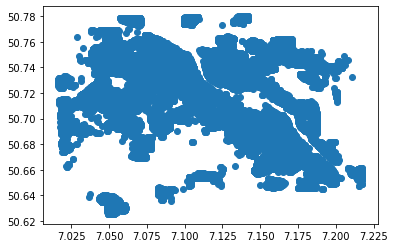

In [36]:
plt.scatter(x='longitude', y='latitude', data=df_resi_sub.select(['longitude','latitude']).toPandas())

In [37]:
df_resi_sub.where(df_resi_sub['storeys_above_ground'].isNull()).toPandas()

,building_function,storeys_above_ground,family_home,living_space,calculated_storeys,garage_parking_lots,solar_area,longitude,latitude,alkis_construction_year,alkis_parcel_area,alkis_floor_area,alkis_attic_conversion,municipality_key,dormer_number,converted_attic
0,Wohnhaus,None,Single,177.339996,4.0,NaN,NaN,7.172823,50.686604,NaN,352.0,NaN,NaN,05314000,9.0,1.0
1,Wohngebäude mit Gemeinbedarf,None,Multi,484.269989,5.0,NaN,0.00,7.170154,50.682630,NaN,403.0,NaN,NaN,05314000,7.0,1.0
2,Wohngebäude mit Gemeinbedarf,None,Single,279.820007,4.0,NaN,0.00,7.170523,50.681933,NaN,526.0,NaN,NaN,05314000,4.0,1.0
3,Wohngebäude mit Gemeinbedarf,None,Single,308.579987,4.0,NaN,0.00,7.170401,50.684632,NaN,195.0,NaN,NaN,05314000,4.0,1.0
4,Wohnhaus,None,Single,389.359985,4.0,NaN,0.00,7.166636,50.681545,NaN,713.0,NaN,NaN,05314000,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83264,Wohnhaus,None,Single,245.500000,2.0,NaN,0.00,7.087153,50.640187,NaN,989.0,NaN,NaN,05382072,7.0,1.0
83265,Wohnhaus,None,Single,31.780001,1.0,NaN,0.00,7.018843,50.694029,NaN,744.0,NaN,NaN,05382004,0.0,0.0
83266,Wohnhaus,None,Single,171.179993,2.0,NaN,0.00,7.018146,50.727846,NaN,283.0,NaN,NaN,05382004,3.0,1.0
83267,Wohnhaus,None,Single,179.389999,3.0,NaN,0.00,7.183978,50.706337,NaN,309.0,NaN,NaN,05382024,0.0,0.0


Change the null value of storeys_above_ground to 0 since it indicates the property does not have any storeys above the ground.

In [38]:
df_resi_sub[['storeys_above_ground']].na.fill(value=0).show()

+--------------------+
|storeys_above_ground|
+--------------------+
|                   0|
|                   0|
|                   0|
|                   0|
|                   0|
|                   0|
|                   0|
|                   0|
|                   0|
|                   0|
|                   0|
|                   0|
|                   0|
|                   0|
|                   0|
|                   0|
|                   0|
|                   0|
|                   0|
|                   0|
+--------------------+
only showing top 20 rows



In [39]:
df_resi_sub = df_resi_sub.na.fill(value=0, subset='storeys_above_ground')

In [40]:
df_resi_sub.toPandas()

,building_function,storeys_above_ground,family_home,living_space,calculated_storeys,garage_parking_lots,solar_area,longitude,latitude,alkis_construction_year,alkis_parcel_area,alkis_floor_area,alkis_attic_conversion,municipality_key,dormer_number,converted_attic
0,Wohnhaus,0,Single,177.339996,4.0,NaN,NaN,7.172823,50.686604,NaN,352.0,NaN,NaN,05314000,9.0,1.0
1,Wohngebäude mit Gemeinbedarf,0,Multi,484.269989,5.0,NaN,0.00,7.170154,50.682630,NaN,403.0,NaN,NaN,05314000,7.0,1.0
2,Wohngebäude mit Gemeinbedarf,0,Single,279.820007,4.0,NaN,0.00,7.170523,50.681933,NaN,526.0,NaN,NaN,05314000,4.0,1.0
3,Wohngebäude mit Gemeinbedarf,0,Single,308.579987,4.0,NaN,0.00,7.170401,50.684632,NaN,195.0,NaN,NaN,05314000,4.0,1.0
4,Wohnhaus,0,Single,389.359985,4.0,NaN,0.00,7.166636,50.681545,NaN,713.0,NaN,NaN,05314000,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83398,Wohnhaus,0,Single,245.500000,2.0,NaN,0.00,7.087153,50.640187,NaN,989.0,NaN,NaN,05382072,7.0,1.0
83399,Wohnhaus,0,Single,31.780001,1.0,NaN,0.00,7.018843,50.694029,NaN,744.0,NaN,NaN,05382004,0.0,0.0
83400,Wohnhaus,0,Single,171.179993,2.0,NaN,0.00,7.018146,50.727846,NaN,283.0,NaN,NaN,05382004,3.0,1.0
83401,Wohnhaus,0,Single,179.389999,3.0,NaN,0.00,7.183978,50.706337,NaN,309.0,NaN,NaN,05382024,0.0,0.0


In [41]:
from pyspark.sql.functions import col,isnan, when, count

In [42]:
df_resi_sub.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_resi_sub.columns]
   ).toPandas()

,building_function,storeys_above_ground,family_home,living_space,calculated_storeys,garage_parking_lots,solar_area,longitude,latitude,alkis_construction_year,alkis_parcel_area,alkis_floor_area,alkis_attic_conversion,municipality_key,dormer_number,converted_attic
0,0,0,0,0,145,83400,20478,0,0,83403,346,83403,83376,343,59,59


* calculated_storeys can be omitted or filled, depends on whether it is categorical or numerical.
* garage_parking_lots null datas can be filled with 0
* solar_area null datas account for 25%
* alkis_construction_year column can be omitted since it contains too many null values
* alkis_parcel_are null datas can be omitted
* alkis_floor_area column can be omitted since it contains too many null values
* alkis_attic_conversion column can be omitted since it contains too many null values, altered with another attic feature (converted_attic)
* municipality_key and dormer_number null data can be omitted. 

In [43]:
df_resi_sub[['calculated_storeys']].distinct().show()

+------------------+
|calculated_storeys|
+------------------+
|                12|
|              null|
|                 1|
|                13|
|                 6|
|                 3|
|                 5|
|                15|
|                 9|
|                 4|
|                 8|
|                 7|
|                10|
|                11|
|                14|
|                 2|
|                18|
+------------------+



In [44]:
df_resi_sub = df_resi_sub.dropna(subset='calculated_storeys')
df_resi_sub[['calculated_storeys']].distinct().show()

+------------------+
|calculated_storeys|
+------------------+
|                12|
|                 1|
|                13|
|                 6|
|                 3|
|                 5|
|                15|
|                 9|
|                 4|
|                 8|
|                 7|
|                10|
|                11|
|                14|
|                 2|
|                18|
+------------------+



In [45]:
df_resi_sub = df_resi_sub.na.fill(value=0, subset='garage_parking_lots')
df_resi_sub[['garage_parking_lots']].distinct().show()

+-------------------+
|garage_parking_lots|
+-------------------+
|                1.0|
|                0.0|
+-------------------+



In [46]:
df_resi_sub[['solar_area']].distinct().show()

+----------+
|solar_area|
+----------+
|     23.04|
|      64.2|
|     12.32|
|     17.95|
|      13.4|
|     46.15|
|      8.51|
|      14.9|
|     35.17|
|     16.75|
|     23.06|
|     15.92|
|     24.19|
|      9.55|
|     73.02|
|     49.56|
|     27.91|
|     21.89|
|      8.73|
|     18.78|
+----------+
only showing top 20 rows



In [47]:
df_resi_sub.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_resi_sub.columns]
   ).toPandas()

,building_function,storeys_above_ground,family_home,living_space,calculated_storeys,garage_parking_lots,solar_area,longitude,latitude,alkis_construction_year,alkis_parcel_area,alkis_floor_area,alkis_attic_conversion,municipality_key,dormer_number,converted_attic
0,0,0,0,0,0,0,20413,0,0,83258,345,83258,83232,342,58,58


In [48]:
df_resi_sub[['living_space','solar_area']].toPandas()

,living_space,solar_area
0,177.339996,NaN
1,484.269989,0.00
2,279.820007,0.00
3,308.579987,0.00
4,389.359985,0.00
...,...,...
83253,245.500000,0.00
83254,31.780001,0.00
83255,171.179993,0.00
83256,179.389999,0.00


In [49]:
df_resi_sub[['solar_area']].toPandas().describe()

,solar_area
count,62845.000000
mean,0.686105
std,5.278434
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,321.690000


Fill the NaN of solar_area with mean average

In [50]:
mean_solar = df_resi_sub[['solar_area']].toPandas().mean()
df_resi_sub = df_resi_sub.na.fill(value=mean_solar.values[0], subset='solar_area')

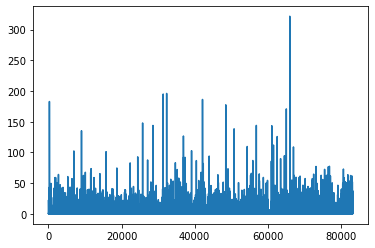

In [51]:
plt.plot(df_resi_sub[['solar_area']].toPandas())

In [52]:
df_resi_sub = df_resi_sub.dropna(subset=['alkis_parcel_area','municipality_key','dormer_number', 'converted_attic'])
df_resi_sub.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_resi_sub.columns]
   ).toPandas()

,building_function,storeys_above_ground,family_home,living_space,calculated_storeys,garage_parking_lots,solar_area,longitude,latitude,alkis_construction_year,alkis_parcel_area,alkis_floor_area,alkis_attic_conversion,municipality_key,dormer_number,converted_attic
0,0,0,0,0,0,0,0,0,0,82913,0,82913,82887,0,0,0


In [53]:
df_resi_sub = df_resi_sub.drop('alkis_construction_year','alkis_floor_area','alkis_attic_conversion')
len(df_resi_sub.columns)

13

In [54]:
df_resi_sub.printSchema() 

root
 |-- building_function: string (nullable = true)
 |-- storeys_above_ground: decimal(8,0) (nullable = true)
 |-- family_home: string (nullable = true)
 |-- living_space: float (nullable = true)
 |-- calculated_storeys: integer (nullable = true)
 |-- garage_parking_lots: float (nullable = false)
 |-- solar_area: double (nullable = false)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- alkis_parcel_area: double (nullable = true)
 |-- municipality_key: string (nullable = true)
 |-- dormer_number: double (nullable = true)
 |-- converted_attic: integer (nullable = true)



In [55]:
df_resi_sub.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_resi_sub.columns]
   ).toPandas()

,building_function,storeys_above_ground,family_home,living_space,calculated_storeys,garage_parking_lots,solar_area,longitude,latitude,alkis_parcel_area,municipality_key,dormer_number,converted_attic
0,0,0,0,0,0,0,0,0,0,0,0,0,0


The sub-data has no null values.

# Indexer for categorical datas

In [56]:
df_resi_sub.toPandas().describe()

,living_space,calculated_storeys,garage_parking_lots,solar_area,longitude,latitude,alkis_parcel_area,dormer_number,converted_attic
count,82913.000000,82913.000000,82913.000000,82913.000000,82913.000000,82913.000000,82913.000000,82913.000000,82913.000000
mean,205.585709,2.746288,0.000036,0.686085,7.113544,50.713372,1229.712976,1.366131,0.353033
std,328.616455,1.220102,0.006015,4.587133,0.048797,0.033036,5587.181292,2.513790,0.477916
min,0.100000,1.000000,0.000000,0.000000,7.016235,50.625570,1.000000,0.000000,0.000000
25%,82.180000,2.000000,0.000000,0.000000,7.071299,50.691498,266.000000,0.000000,0.000000
50%,135.460007,3.000000,0.000000,0.000000,7.113043,50.715210,429.000000,0.000000,0.000000
75%,217.300003,3.000000,0.000000,0.686105,7.156929,50.739691,723.000000,2.000000,1.000000
max,14490.200195,18.000000,1.000000,321.690000,7.217563,50.779934,288595.000000,37.000000,1.000000


In [57]:
df_resi_sub[['garage_parking_lots','converted_attic']].distinct().show()

+-------------------+---------------+
|garage_parking_lots|converted_attic|
+-------------------+---------------+
|                1.0|              0|
|                0.0|              0|
|                0.0|              1|
|                1.0|              1|
+-------------------+---------------+



garage_parking_lots and converted_attic are categorical data that is already encoded: 1: yes 0: no

#### Index the string categorical data : building_function and municipality_key

In [58]:
df_resi_sub[['building_function']].distinct().show()

+--------------------+
|   building_function|
+--------------------+
|Land- und forstwi...|
|Wohngebäude mit G...|
|Studenten-, Schül...|
|Wohn- und Geschäf...|
|Wohn- und Verwalt...|
|         Wohngebäude|
|Wohn- und Bürogeb...|
|Land- und forstwi...|
|            Wohnhaus|
|Gebäude für Hande...|
|  Schwesternwohnheim|
|Wohn- und Wirtsch...|
|Gemischt genutzte...|
|Wohngebäude mit G...|
|Wohngebäude mit H...|
|Gebäude für Gewer...|
|            Wohnheim|
+--------------------+



In [59]:
df_resi_sub[['municipality_key']].distinct().show()

+----------------+
|municipality_key|
+----------------+
|        05382008|
|        05382072|
|        05382044|
|        05314000|
|        05382032|
|        05382012|
|        05382004|
|        05382024|
|        05382068|
|        05382056|
+----------------+



In [60]:
from pyspark.ml.feature import VectorIndexer, StringIndexer
# transform the features
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import RobustScaler, StandardScaler
from pyspark.ml import Pipeline

## VectorAssembler numerical features and categorical features

In [61]:
df_resi_sub.columns

['building_function',
 'storeys_above_ground',
 'family_home',
 'living_space',
 'calculated_storeys',
 'garage_parking_lots',
 'solar_area',
 'longitude',
 'latitude',
 'alkis_parcel_area',
 'municipality_key',
 'dormer_number',
 'converted_attic']

In [62]:
cate_cols=['building_function','storeys_above_ground','family_home','garage_parking_lots','municipality_key','converted_attic']

#indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_resi_sub).transform(df_resi_sub) for column in cate_cols]

In [63]:
for column in cate_cols:
    indexer = StringIndexer(inputCol=column, outputCol=column+"_indexed")
    df_resi_sub = indexer.fit(df_resi_sub).transform(df_resi_sub)

In [64]:
df_resi_sub.columns

['building_function',
 'storeys_above_ground',
 'family_home',
 'living_space',
 'calculated_storeys',
 'garage_parking_lots',
 'solar_area',
 'longitude',
 'latitude',
 'alkis_parcel_area',
 'municipality_key',
 'dormer_number',
 'converted_attic',
 'building_function_indexed',
 'storeys_above_ground_indexed',
 'family_home_indexed',
 'garage_parking_lots_indexed',
 'municipality_key_indexed',
 'converted_attic_indexed']

In [65]:
df_resi_sub.toPandas().head()

,building_function,storeys_above_ground,family_home,living_space,calculated_storeys,garage_parking_lots,solar_area,longitude,latitude,alkis_parcel_area,municipality_key,dormer_number,converted_attic,building_function_indexed,storeys_above_ground_indexed,family_home_indexed,garage_parking_lots_indexed,municipality_key_indexed,converted_attic_indexed
0,Wohnhaus,0,Single,177.339996,4,0.0,0.686105,7.172823,50.686604,352.0,05314000,9.0,1,1.0,0.0,0.0,0.0,0.0,1.0
1,Wohngebäude mit Gemeinbedarf,0,Multi,484.269989,5,0.0,0.000000,7.170154,50.682630,403.0,05314000,7.0,1,0.0,0.0,1.0,0.0,0.0,1.0
2,Wohngebäude mit Gemeinbedarf,0,Single,279.820007,4,0.0,0.000000,7.170523,50.681933,526.0,05314000,4.0,1,0.0,0.0,0.0,0.0,0.0,1.0
3,Wohngebäude mit Gemeinbedarf,0,Single,308.579987,4,0.0,0.000000,7.170401,50.684632,195.0,05314000,4.0,1,0.0,0.0,0.0,0.0,0.0,1.0
4,Wohnhaus,0,Single,389.359985,4,0.0,0.000000,7.166636,50.681545,713.0,05314000,6.0,1,1.0,0.0,0.0,0.0,0.0,1.0


## Scale the numerical data

In [77]:
nume_assembler = VectorAssembler(inputCols=['living_space','calculated_storeys','solar_area','longitude','latitude','alkis_parcel_area',
                                            'dormer_number'],
                               outputCol='nume_features')

In [78]:
df_resi_nume = nume_assembler.transform(df_resi_sub)

In [79]:
scaler = StandardScaler(inputCol="nume_features", outputCol="scaledFeatures",
                       withStd = True, withMean=False)

In [90]:
scalerModel = scaler.fit(df_resi_nume)
df_resi_scaled = scalerModel.transform(df_resi_nume)

In [91]:
df_resi_scaled.toPandas().head()

,building_function,storeys_above_ground,family_home,living_space,calculated_storeys,garage_parking_lots,solar_area,longitude,latitude,alkis_parcel_area,...,dormer_number,converted_attic,building_function_indexed,storeys_above_ground_indexed,family_home_indexed,garage_parking_lots_indexed,municipality_key_indexed,converted_attic_indexed,nume_features,scaledFeatures
0,Wohnhaus,0,Single,177.339996,4,0.0,0.686105,7.172823,50.686604,352.0,...,9.0,1,1.0,0.0,0.0,0.0,0.0,1.0,"[177.33999633789062, 4.0, 0.6861051794096586, ...","[0.5396564961130015, 3.2784135854260925, 0.149..."
1,Wohngebäude mit Gemeinbedarf,0,Multi,484.269989,5,0.0,0.000000,7.170154,50.682630,403.0,...,7.0,1,0.0,0.0,1.0,0.0,0.0,1.0,"[484.2699890136719, 5.0, 0.0, 7.17015430391212...","[1.473663306871073, 4.0980169817826155, 0.0, 1..."
2,Wohngebäude mit Gemeinbedarf,0,Single,279.820007,4,0.0,0.000000,7.170523,50.681933,526.0,...,4.0,1,0.0,0.0,0.0,0.0,0.0,1.0,"[279.82000732421875, 4.0, 0.0, 7.1705226907804...","[0.8515094609970851, 3.2784135854260925, 0.0, ..."
3,Wohngebäude mit Gemeinbedarf,0,Single,308.579987,4,0.0,0.000000,7.170401,50.684632,195.0,...,4.0,1,0.0,0.0,0.0,0.0,0.0,1.0,"[308.5799865722656, 4.0, 0.0, 7.17040080363530...","[0.9390278434814964, 3.2784135854260925, 0.0, ..."
4,Wohnhaus,0,Single,389.359985,4,0.0,0.000000,7.166636,50.681545,713.0,...,6.0,1,1.0,0.0,0.0,0.0,0.0,1.0,"[389.3599853515625, 4.0, 0.0, 7.16663557942902...","[1.1848463390124657, 3.2784135854260925, 0.0, ..."


In [92]:
df_resi_scaled = df_resi_scaled.drop('building_function','storeys_above_ground','family_home','garage_parking_lots','municipality_key','converted_attic')
df_resi_scaled.columns

['living_space',
 'calculated_storeys',
 'solar_area',
 'longitude',
 'latitude',
 'alkis_parcel_area',
 'dormer_number',
 'building_function_indexed',
 'storeys_above_ground_indexed',
 'family_home_indexed',
 'garage_parking_lots_indexed',
 'municipality_key_indexed',
 'converted_attic_indexed',
 'nume_features',
 'scaledFeatures']

In [93]:
len(df_resi_scaled.columns)

15

In [94]:
vec_assembler = VectorAssembler(inputCols=['building_function_indexed',
                                         'storeys_above_ground_indexed',
                                         'family_home_indexed',
                                         'garage_parking_lots_indexed',
                                         'municipality_key_indexed',
                                         'converted_attic_indexed','scaledFeatures'],outputCol='features')
df_resi_final = vec_assembler.transform(df_resi_scaled)
df_resi_final.toPandas().head()

,living_space,calculated_storeys,solar_area,longitude,latitude,alkis_parcel_area,dormer_number,building_function_indexed,storeys_above_ground_indexed,family_home_indexed,garage_parking_lots_indexed,municipality_key_indexed,converted_attic_indexed,nume_features,scaledFeatures,features
0,177.339996,4,0.686105,7.172823,50.686604,352.0,9.0,1.0,0.0,0.0,0.0,0.0,1.0,"[177.33999633789062, 4.0, 0.6861051794096586, ...","[0.5396564961130015, 3.2784135854260925, 0.149...","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.5396564961130..."
1,484.269989,5,0.000000,7.170154,50.682630,403.0,7.0,0.0,0.0,1.0,0.0,0.0,1.0,"[484.2699890136719, 5.0, 0.0, 7.17015430391212...","[1.473663306871073, 4.0980169817826155, 0.0, 1...","[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.4736633068710..."
2,279.820007,4,0.000000,7.170523,50.681933,526.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,"[279.82000732421875, 4.0, 0.0, 7.1705226907804...","[0.8515094609970851, 3.2784135854260925, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.8515094609970..."
3,308.579987,4,0.000000,7.170401,50.684632,195.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,"[308.5799865722656, 4.0, 0.0, 7.17040080363530...","[0.9390278434814964, 3.2784135854260925, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.9390278434814..."
4,389.359985,4,0.000000,7.166636,50.681545,713.0,6.0,1.0,0.0,0.0,0.0,0.0,1.0,"[389.3599853515625, 4.0, 0.0, 7.16663557942902...","[1.1848463390124657, 3.2784135854260925, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.1848463390124..."


# K-means

In [193]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [194]:
# Trains a k-means model
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='features', k=i)
    f
    KMeans_fit=KMeans_algo.fit(df_resi_final)
    
    output=KMeans_fit.transform(df_resi_final)
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.824108423182685


Silhouette Score: 0.388062120594217


Silhouette Score: 0.28793660176809704


Silhouette Score: 0.25901384383938286


Silhouette Score: 0.36415832557345573


Silhouette Score: 0.3185662303353724


Silhouette Score: 0.42766876486077376


Silhouette Score: 0.2932449629286254


Text(0, 0.5, 'cost')

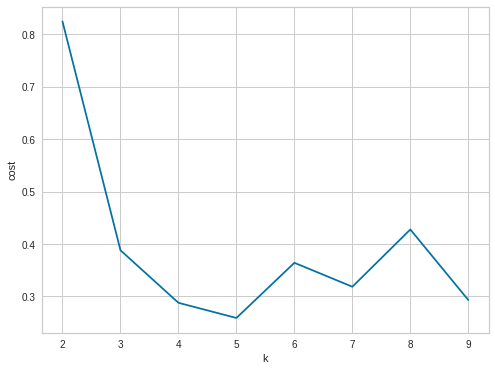

In [195]:
#Visualizing the silhouette scores in a plot

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [197]:
np.mean(silhouette_score)

0.39534490913532616

In [ ]:
break

# Train the model

#### Choose k = 8

In [198]:
# Train a k-means model
kmeans = KMeans(featuresCol='features',k=8)
model  = kmeans.fit(df_resi_final)    
output = model.transform(df_resi_final)
score  = evaluator.evaluate(output)

In [199]:
print("Silhouette score: ", score)

Silhouette score:  0.42766876486077376


In [200]:
# Show the result
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[9.58302711e-02 1.06370634e-03 2.17189494e-02 0.00000000e+00
 5.85038487e-02 2.25911886e-01 4.00530642e-01 1.88095381e+00
 5.40870946e-02 1.45693701e+02 1.53514745e+03 1.63489210e-01
 2.04511528e-01]
[9.31745449e-02 8.39410314e-04 3.51817848e-01 0.00000000e+00
 2.67562038e-02 7.26509627e-01 1.30370975e+00 3.46481413e+00
 7.48089075e-02 1.45808406e+02 1.53523580e+03 2.73330913e-01
 1.55614038e+00]
[2.72727273e-01 0.00000000e+00 4.03409091e-01 0.00000000e+00
 2.15909091e-01 7.95454545e-02 2.50177340e+00 2.24925250e+00
 5.60893737e-02 1.45633731e+02 1.53526358e+03 1.76247830e+01
 1.60478465e-01]
[7.17291507e-01 4.97322112e-03 3.40474369e-02 0.00000000e+00
 5.27276205e+00 2.73527161e-01 4.68648544e-01 1.77434415e+00
 8.28846554e-02 1.45303630e+02 1.53288314e+03 1.21777485e-01
 3.32214997e-01]
[8.33333333e-02 0.00000000e+00 6.38888889e-01 0.00000000e+00
 0.00000000e+00 5.55555556e-02 2.94815929e+00 2.32220962e+00
 2.73502931e+01 1.46028070e+02 1.53496918e+03 5.72182774e-01

In [201]:
# Predict
predictions = model.transform(df_resi_final)

In [202]:
predictions.select("prediction").show(10)

+----------+
|prediction|
+----------+
|         1|
|         1|
|         1|
|         1|
|         1|
|         0|
|         0|
|         1|
|         1|
|         1|
+----------+
only showing top 10 rows



In [203]:
predictions.select("prediction").distinct().show()

+----------+
|prediction|
+----------+
|         1|
|         6|
|         3|
|         5|
|         4|
|         7|
|         2|
|         0|
+----------+



In [204]:
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|19380|
|         6| 2287|
|         3| 2614|
|         5|  947|
|         4|   36|
|         7| 6085|
|         2|  176|
|         0|51388|
+----------+-----+



In [205]:
df_resi_final.toPandas().head(3)

,living_space,calculated_storeys,solar_area,longitude,latitude,alkis_parcel_area,dormer_number,building_function_indexed,storeys_above_ground_indexed,family_home_indexed,garage_parking_lots_indexed,municipality_key_indexed,converted_attic_indexed,nume_features,scaledFeatures,features
0,177.339996,4,0.686105,7.172823,50.686604,352.0,9.0,1.0,0.0,0.0,0.0,0.0,1.0,"[177.33999633789062, 4.0, 0.6861051794096586, ...","[0.5396564961130015, 3.2784135854260925, 0.149...","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.5396564961130..."
1,484.269989,5,0.000000,7.170154,50.682630,403.0,7.0,0.0,0.0,1.0,0.0,0.0,1.0,"[484.2699890136719, 5.0, 0.0, 7.17015430391212...","[1.473663306871073, 4.0980169817826155, 0.0, 1...","[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.4736633068710..."
2,279.820007,4,0.000000,7.170523,50.681933,526.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,"[279.82000732421875, 4.0, 0.0, 7.1705226907804...","[0.8515094609970851, 3.2784135854260925, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.8515094609970..."


In [206]:
temp = df_resi_final.select("features").rdd.map(lambda x: x[0].toArray().tolist()).toDF()

In [207]:
temp.show(3)

+---+---+---+---+---+---+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+
| _1| _2| _3| _4| _5| _6|                _7|                _8|                 _9|               _10|               _11|                _12|               _13|
+---+---+---+---+---+---+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+
|1.0|0.0|0.0|0.0|0.0|1.0|0.5396564961130015|3.2784135854260925|0.14957166323337293|146.99312532155514|1534.3069695940103|0.06300135642503567| 3.580251951643275|
|0.0|0.0|1.0|0.0|0.0|1.0| 1.473663306871073|4.0980169817826155|                0.0|146.93842952732007|1534.1866621207844|0.07212939386161754| 2.784640406833658|
|0.0|0.0|0.0|0.0|0.0|1.0|0.8515094609970851|3.2784135854260925|                0.0|146.94597890291192|1534.1655564669788|0.09414407238513853|1.5912230896192332|
+---+---+---+---+---+---+---------

In [208]:
from pyspark.sql import functions as f

In [209]:
data_result = predictions.select("prediction")
data_result.columns

['prediction']

In [210]:
# Predict
temp = temp.withColumn('row_index', f.monotonically_increasing_id())
data_result = data_result.withColumn('row_index', f.monotonically_increasing_id())
temp = temp.join(data_result, on=["row_index"]).sort("row_index").drop("row_index")

In [211]:
temp.show(3)

+---+---+---+---+---+---+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+----------+
| _1| _2| _3| _4| _5| _6|                _7|                _8|                 _9|               _10|               _11|                _12|               _13|prediction|
+---+---+---+---+---+---+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+----------+
|1.0|0.0|0.0|0.0|0.0|1.0|0.5396564961130015|3.2784135854260925|0.14957166323337293|146.99312532155514|1534.3069695940103|0.06300135642503567| 3.580251951643275|         1|
|0.0|0.0|1.0|0.0|0.0|1.0| 1.473663306871073|4.0980169817826155|                0.0|146.93842952732007|1534.1866621207844|0.07212939386161754| 2.784640406833658|         1|
|0.0|0.0|0.0|0.0|0.0|1.0|0.8515094609970851|3.2784135854260925|                0.0|146.94597890291192|1534.1655564669788|0.09414407238513853

In [212]:
temp = temp.select(col("_10").alias("longitude"), col("_11").alias("latitude"), "prediction")

In [213]:
df_visual = temp.toPandas()

In [214]:
# Visualization
import pandas as pd
centers_df = pd.DataFrame(centers)
centers_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.095830,0.001064,0.021719,0.0,0.058504,0.225912,0.400531,1.880954,0.054087,145.693701,1535.147454,0.163489,0.204512
1,0.093175,0.000839,0.351818,0.0,0.026756,0.726510,1.303710,3.464814,0.074809,145.808406,1535.235799,0.273331,1.556140
2,0.272727,0.000000,0.403409,0.0,0.215909,0.079545,2.501773,2.249253,0.056089,145.633731,1535.263583,17.624783,0.160478
3,0.717292,0.004973,0.034047,0.0,5.272762,0.273527,0.468649,1.774344,0.082885,145.303630,1532.883140,0.121777,0.332215
4,0.083333,0.000000,0.638889,0.0,0.000000,0.055556,2.948159,2.322210,27.350293,146.028070,1534.969181,0.572183,0.176803


In [231]:
from sklearn.preprocessing import MinMaxScaler

In [232]:
sk_scaler = MinMaxScaler()
sk_scaler.fit(df_visual[['longitude','latitude']])
df_visual_scaled = sk_scaler.transform(df_visual[['longitude','latitude']])

In [233]:
df_visual_scaled

array([[0.77777672, 0.39539425],
       [0.76451984, 0.36964712],
       [0.76634961, 0.36513028],
       ...,
       [0.00949331, 0.66256819],
       [0.83318261, 0.52322663],
       [0.10771007, 0.60467536]])

In [234]:
df_visual_scaled = pd.DataFrame(df_visual_scaled,columns=['longitude','latitude'])
df_visual_scaled

,longitude,latitude
0,0.777777,0.395394
1,0.764520,0.369647
2,0.766350,0.365130
3,0.765744,0.382617
4,0.747042,0.362616
...,...,...
82908,0.352252,0.094694
82909,0.012954,0.443493
82910,0.009493,0.662568
82911,0.833183,0.523227


In [235]:
df_visual_scaled['prediction'] = df_visual['prediction']

In [237]:
df_visual_scaled.head()

,longitude,latitude,prediction
0,0.777777,0.395394,1
1,0.764520,0.369647,1
2,0.766350,0.365130,1
3,0.765744,0.382617,1
4,0.747042,0.362616,1


/home/vhdinh/.local/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


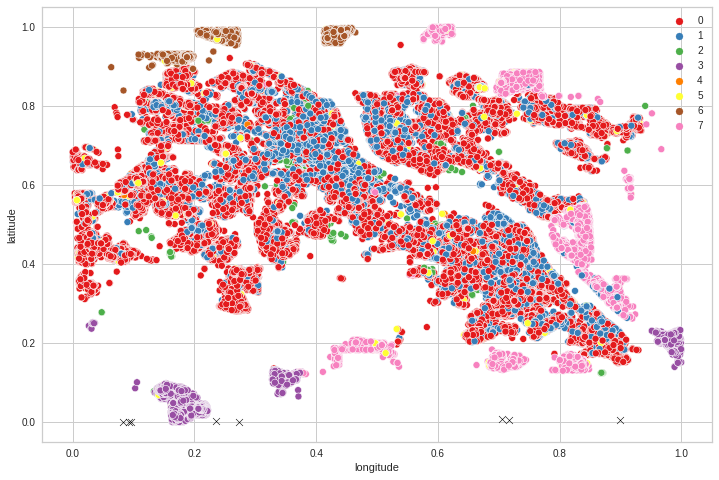

In [241]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(x="longitude", y="latitude", data =df_visual_scaled,
               hue="prediction",
               # size = "prediction",
               palette = "Set1")

#centers
sns.scatterplot(data=centers_df, x=0,y=1,color="black",marker="x")
plt.show()
fig.savefig('Cluster_8.png')

When we visualize the clusters regarding latitude and longitude, we see overlapping clusters. The graph shows an influence of location on the groups of residential buildings. Specifically, the buildings on the outskirt of the city make into a group while central region has higher density of buildings. This could raise an insights regarding the purpose of use and location will determine the equipments' quality of the house.

Cluster 0 and 1 accounts for most of our residential buildings data.

In [243]:
# save my model
model.save('K_means_8_bonn')

#### Choose k = 6

In [244]:
# Train a k-means model
kmeans = KMeans(featuresCol='features',k=6)
model  = kmeans.fit(df_resi_final)    
output = model.transform(df_resi_final)
score  = evaluator.evaluate(output)

In [245]:
print("Silhouette score: ", score)

Silhouette score:  0.36415832557345573


In [246]:
# Show the result
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[9.81528432e-02 1.10668437e-03 2.76268663e-02 0.00000000e+00
 5.94591332e-02 1.79363355e-01 4.06626032e-01 1.86146513e+00
 1.52045458e-01 1.45678059e+02 1.53515457e+03 1.70464689e-01
 1.41767034e-01]
[9.61746577e-02 8.46939256e-04 2.74078954e-01 0.00000000e+00
 3.90062579e-02 7.94664283e-01 9.61557681e-01 3.28643492e+00
 1.04584068e-01 1.45835258e+02 1.53520852e+03 2.03267433e-01
 1.57594950e+00]
[1.45244216e-01 0.00000000e+00 1.00000000e+00 0.00000000e+00
 4.37017995e-02 7.32647815e-02 7.58986116e+00 4.06219884e+00
 7.77642170e-01 1.45697408e+02 1.53523834e+03 1.47994018e+00
 2.28559358e-01]
[7.11644627e-01 6.41930928e-03 4.27525998e-02 3.85158557e-04
 3.23327770e+00 2.88098601e-01 4.70006849e-01 1.86481081e+00
 1.74935526e-01 1.46340754e+02 1.53408234e+03 1.25151421e-01
 3.54649285e-01]
[2.94478528e-01 0.00000000e+00 3.61963190e-01 0.00000000e+00
 2.33128834e-01 8.58895706e-02 1.60617298e+00 2.12694624e+00
 5.32218188e-02 1.45624970e+02 1.53525145e+03 1.82285140e+01

In [247]:
# Predict
predictions = model.transform(df_resi_final)

In [248]:
predictions.select("prediction").show(10)

+----------+
|prediction|
+----------+
|         1|
|         1|
|         1|
|         1|
|         1|
|         0|
|         0|
|         1|
|         1|
|         1|
+----------+
only showing top 10 rows



In [249]:
predictions.select("prediction").distinct().show()

+----------+
|prediction|
+----------+
|         1|
|         3|
|         5|
|         4|
|         2|
|         0|
+----------+



In [250]:
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|21253|
|         3| 7788|
|         5| 3232|
|         4|  163|
|         2|  805|
|         0|49672|
+----------+-----+



In [251]:
df_resi_final.toPandas().head(3)

,living_space,calculated_storeys,solar_area,longitude,latitude,alkis_parcel_area,dormer_number,building_function_indexed,storeys_above_ground_indexed,family_home_indexed,garage_parking_lots_indexed,municipality_key_indexed,converted_attic_indexed,nume_features,scaledFeatures,features
0,177.339996,4,0.686105,7.172823,50.686604,352.0,9.0,1.0,0.0,0.0,0.0,0.0,1.0,"[177.33999633789062, 4.0, 0.6861051794096586, ...","[0.5396564961130015, 3.2784135854260925, 0.149...","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.5396564961130..."
1,484.269989,5,0.000000,7.170154,50.682630,403.0,7.0,0.0,0.0,1.0,0.0,0.0,1.0,"[484.2699890136719, 5.0, 0.0, 7.17015430391212...","[1.473663306871073, 4.0980169817826155, 0.0, 1...","[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.4736633068710..."
2,279.820007,4,0.000000,7.170523,50.681933,526.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,"[279.82000732421875, 4.0, 0.0, 7.1705226907804...","[0.8515094609970851, 3.2784135854260925, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.8515094609970..."


In [252]:
temp = df_resi_final.select("features").rdd.map(lambda x: x[0].toArray().tolist()).toDF()

In [253]:
temp.show(3)

+---+---+---+---+---+---+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+
| _1| _2| _3| _4| _5| _6|                _7|                _8|                 _9|               _10|               _11|                _12|               _13|
+---+---+---+---+---+---+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+
|1.0|0.0|0.0|0.0|0.0|1.0|0.5396564961130015|3.2784135854260925|0.14957166323337293|146.99312532155514|1534.3069695940103|0.06300135642503567| 3.580251951643275|
|0.0|0.0|1.0|0.0|0.0|1.0| 1.473663306871073|4.0980169817826155|                0.0|146.93842952732007|1534.1866621207844|0.07212939386161754| 2.784640406833658|
|0.0|0.0|0.0|0.0|0.0|1.0|0.8515094609970851|3.2784135854260925|                0.0|146.94597890291192|1534.1655564669788|0.09414407238513853|1.5912230896192332|
+---+---+---+---+---+---+---------

In [254]:
from pyspark.sql import functions as f

In [255]:
data_result = predictions.select("prediction")
data_result.columns

['prediction']

In [256]:
# Predict
temp = temp.withColumn('row_index', f.monotonically_increasing_id())
data_result = data_result.withColumn('row_index', f.monotonically_increasing_id())
temp = temp.join(data_result, on=["row_index"]).sort("row_index").drop("row_index")

In [257]:
temp.show(3)

+---+---+---+---+---+---+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+----------+
| _1| _2| _3| _4| _5| _6|                _7|                _8|                 _9|               _10|               _11|                _12|               _13|prediction|
+---+---+---+---+---+---+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+----------+
|1.0|0.0|0.0|0.0|0.0|1.0|0.5396564961130015|3.2784135854260925|0.14957166323337293|146.99312532155514|1534.3069695940103|0.06300135642503567| 3.580251951643275|         1|
|0.0|0.0|1.0|0.0|0.0|1.0| 1.473663306871073|4.0980169817826155|                0.0|146.93842952732007|1534.1866621207844|0.07212939386161754| 2.784640406833658|         1|
|0.0|0.0|0.0|0.0|0.0|1.0|0.8515094609970851|3.2784135854260925|                0.0|146.94597890291192|1534.1655564669788|0.09414407238513853

In [258]:
temp = temp.select(col("_10").alias("longitude"), col("_11").alias("latitude"), "prediction")

In [259]:
df_visual = temp.toPandas()

In [260]:
# Visualization
import pandas as pd
centers_df = pd.DataFrame(centers)
centers_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.098153,0.001107,0.027627,0.000000,0.059459,0.179363,0.406626,1.861465,0.152045,145.678059,1535.154575,0.170465,0.141767
1,0.096175,0.000847,0.274079,0.000000,0.039006,0.794664,0.961558,3.286435,0.104584,145.835258,1535.208516,0.203267,1.575950
2,0.145244,0.000000,1.000000,0.000000,0.043702,0.073265,7.589861,4.062199,0.777642,145.697408,1535.238338,1.479940,0.228559
3,0.711645,0.006419,0.042753,0.000385,3.233278,0.288099,0.470007,1.864811,0.174936,146.340754,1534.082342,0.125151,0.354649
4,0.294479,0.000000,0.361963,0.000000,0.233129,0.085890,1.606173,2.126946,0.053222,145.624970,1535.251453,18.228514,0.173277


In [261]:
from sklearn.preprocessing import MinMaxScaler

In [262]:
sk_scaler = MinMaxScaler()
sk_scaler.fit(df_visual[['longitude','latitude']])
df_visual_scaled = sk_scaler.transform(df_visual[['longitude','latitude']])

In [263]:
df_visual_scaled

array([[0.77777672, 0.39539425],
       [0.76451984, 0.36964712],
       [0.76634961, 0.36513028],
       ...,
       [0.00949331, 0.66256819],
       [0.83318261, 0.52322663],
       [0.10771007, 0.60467536]])

In [264]:
df_visual_scaled = pd.DataFrame(df_visual_scaled,columns=['longitude','latitude'])
df_visual_scaled

,longitude,latitude
0,0.777777,0.395394
1,0.764520,0.369647
2,0.766350,0.365130
3,0.765744,0.382617
4,0.747042,0.362616
...,...,...
82908,0.352252,0.094694
82909,0.012954,0.443493
82910,0.009493,0.662568
82911,0.833183,0.523227


In [265]:
df_visual_scaled['prediction'] = df_visual['prediction']

In [266]:
df_visual_scaled.head()

,longitude,latitude,prediction
0,0.777777,0.395394,1
1,0.764520,0.369647,1
2,0.766350,0.365130,1
3,0.765744,0.382617,1
4,0.747042,0.362616,1


/home/vhdinh/.local/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


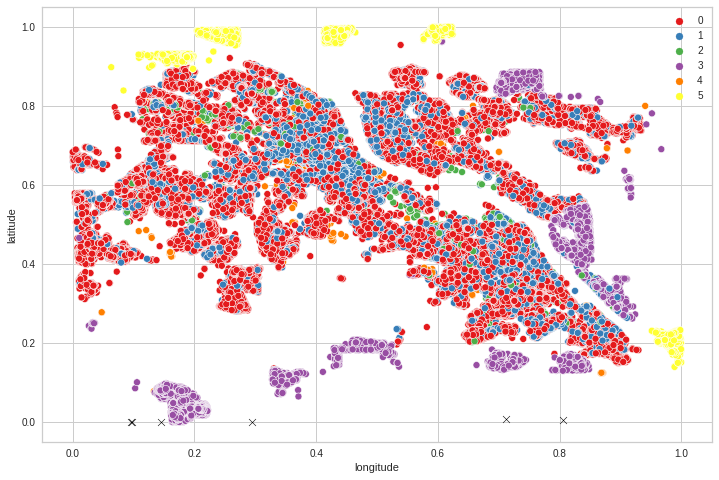

In [267]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(x="longitude", y="latitude", data =df_visual_scaled,
               hue="prediction",
               # size = "prediction",
               palette = "Set1")

#centers
sns.scatterplot(data=centers_df, x=0,y=1,color="black",marker="x")
plt.show()
fig.savefig('Cluster_6_1.png')

Similar assumptions can be made for the case of 6 clusters, compared to the case of 8 clusters, in terms of location of buildings. This could be because we visualize the clusters using latitude and longitude.

# Analyse the clusters result

k = 6

In [270]:
predictions.toPandas()

,living_space,calculated_storeys,solar_area,longitude,latitude,alkis_parcel_area,dormer_number,building_function_indexed,storeys_above_ground_indexed,family_home_indexed,garage_parking_lots_indexed,municipality_key_indexed,converted_attic_indexed,nume_features,scaledFeatures,features,prediction
0,177.339996,4,0.686105,7.172823,50.686604,352.0,9.0,1.0,0.0,0.0,0.0,0.0,1.0,"[177.33999633789062, 4.0, 0.6861051794096586, ...","[0.5396564961130015, 3.2784135854260925, 0.149...","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.5396564961130...",1
1,484.269989,5,0.000000,7.170154,50.682630,403.0,7.0,0.0,0.0,1.0,0.0,0.0,1.0,"[484.2699890136719, 5.0, 0.0, 7.17015430391212...","[1.473663306871073, 4.0980169817826155, 0.0, 1...","[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.4736633068710...",1
2,279.820007,4,0.000000,7.170523,50.681933,526.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,"[279.82000732421875, 4.0, 0.0, 7.1705226907804...","[0.8515094609970851, 3.2784135854260925, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.8515094609970...",1
3,308.579987,4,0.000000,7.170401,50.684632,195.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,"[308.5799865722656, 4.0, 0.0, 7.17040080363530...","[0.9390278434814964, 3.2784135854260925, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.9390278434814...",1
4,389.359985,4,0.000000,7.166636,50.681545,713.0,6.0,1.0,0.0,0.0,0.0,0.0,1.0,"[389.3599853515625, 4.0, 0.0, 7.16663557942902...","[1.1848463390124657, 3.2784135854260925, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.1848463390124...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82908,245.500000,2,0.000000,7.087153,50.640187,989.0,7.0,1.0,0.0,0.0,0.0,3.0,1.0,"[245.5, 2.0, 0.0, 7.087153041997911, 50.640187...","[0.7470715717356471, 1.6392067927130463, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 3.0, 1.0, 0.7470715717356...",3
82909,31.780001,1,0.000000,7.018843,50.694029,744.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,"[31.780000686645508, 1.0, 0.0, 7.0188425551130...","[0.09670849312721876, 0.8196033963565231, 0.0,...","(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0967084931272...",0
82910,171.179993,2,0.000000,7.018146,50.727846,283.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,"[171.17999267578125, 2.0, 0.0, 7.0181458095264...","[0.5209112267942666, 1.6392067927130463, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.5209112267942...",0
82911,179.389999,3,0.000000,7.183978,50.706337,309.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,"[179.38999938964844, 3.0, 0.0, 7.1839780898993...","[0.5458947812532848, 2.4588101890695695, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.5458947812532...",3


In [274]:
predictions.groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|21253|
|         3| 7788|
|         5| 3232|
|         4|  163|
|         2|  805|
|         0|49672|
+----------+-----+



Cluster 0 and cluster 1 dominance the data

In [277]:
predictions.where(predictions['prediction'] == 0).toPandas()

,living_space,calculated_storeys,solar_area,longitude,latitude,alkis_parcel_area,dormer_number,building_function_indexed,storeys_above_ground_indexed,family_home_indexed,garage_parking_lots_indexed,municipality_key_indexed,converted_attic_indexed,nume_features,scaledFeatures,features,prediction
0,164.860001,3,0.000000,7.171778,50.681065,593.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[164.86000061035156, 3.0, 0.0, 7.1717784683092...","[0.5016791029422203, 2.4588101890695695, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5016791029422...",0
1,29.059999,3,0.000000,7.173269,50.686076,1510.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[29.059999465942383, 3.0, 0.0, 7.1732689288707...","[0.08843136242630811, 2.4588101890695695, 0.0,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0884313624263...",0
2,37.310001,1,0.000000,7.168691,50.681907,636.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[37.310001373291016, 1.0, 0.0, 7.1686912249893...","[0.11353662471447525, 0.8196033963565231, 0.0,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1135366247144...",0
3,52.279999,2,0.686105,7.172542,50.687335,10386.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[52.279998779296875, 2.0, 0.6861051794096586, ...","[0.1590912458590103, 1.6392067927130463, 0.149...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1590912458590...",0
4,27.900000,3,0.000000,7.167509,50.682558,2787.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[27.899999618530273, 3.0, 0.0, 7.1675087328263...","[0.0849014116759241, 2.4588101890695695, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0849014116759...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49667,159.869995,3,0.000000,7.039464,50.719393,557.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,"[159.8699951171875, 3.0, 0.0, 7.03946375061164...","[0.486494209880112, 2.4588101890695695, 0.0, 1...","(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.4864942098801...",0
49668,159.580002,3,0.000000,7.039533,50.719425,557.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,"[159.5800018310547, 3.0, 0.0, 7.03953310501188...","[0.48561174250714245, 2.4588101890695695, 0.0,...","(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.4856117425071...",0
49669,31.780001,1,0.000000,7.018843,50.694029,744.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,"[31.780000686645508, 1.0, 0.0, 7.0188425551130...","[0.09670849312721876, 0.8196033963565231, 0.0,...","(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0967084931272...",0
49670,171.179993,2,0.000000,7.018146,50.727846,283.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,"[171.17999267578125, 2.0, 0.0, 7.0181458095264...","[0.5209112267942666, 1.6392067927130463, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.5209112267942...",0


In [299]:
cluster_0 = predictions.where(predictions['prediction'] == 0).toPandas()

In [300]:
cluster_0.describe()

,living_space,calculated_storeys,solar_area,longitude,latitude,alkis_parcel_area,dormer_number,building_function_indexed,storeys_above_ground_indexed,family_home_indexed,garage_parking_lots_indexed,municipality_key_indexed,converted_attic_indexed,prediction
count,49672.000000,49672.000000,49672.000000,49672.000000,49672.000000,49672.000000,49672.000000,49672.000000,49672.000000,49672.000000,49672.0,49672.000000,49672.000000,49672.0
mean,133.715942,2.271320,0.697112,7.108617,50.714608,953.244262,0.354385,0.098104,0.001107,0.027863,0.0,0.059450,0.178692,0.0
std,114.070374,0.802073,4.381462,0.049283,0.028335,2724.386008,0.876947,0.385064,0.040367,0.164581,0.0,0.236467,0.383098,0.0
min,0.100000,1.000000,0.000000,7.016235,50.646497,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
25%,63.297500,2.000000,0.000000,7.067053,50.694094,259.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
50%,115.949997,2.000000,0.000000,7.111635,50.714481,408.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
75%,168.820007,3.000000,0.000000,7.151635,50.739524,678.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
max,1434.579956,4.000000,144.040000,7.204660,50.772797,50964.000000,6.000000,11.000000,2.000000,1.000000,0.0,1.000000,1.000000,0.0


In [307]:
g = globals()

for i in range(1,6):
    varname = 'cluster_{}'.format(i)
    g[varname] = predictions.where(predictions['prediction'] == i).toPandas()
    print("______"+varname+"______")
    display(g[varname].describe())

______cluster_1______


,living_space,calculated_storeys,solar_area,longitude,latitude,alkis_parcel_area,dormer_number,building_function_indexed,storeys_above_ground_indexed,family_home_indexed,garage_parking_lots_indexed,municipality_key_indexed,converted_attic_indexed,prediction
count,21253.000000,21253.000000,21253.000000,21253.000000,21253.000000,21253.000000,21253.000000,21253.000000,21253.000000,21253.000000,21253.0,21253.000000,21253.000000,21253.0
mean,314.277008,4.007340,0.480286,7.116419,50.716374,1121.924858,3.965746,0.096410,0.000847,0.272338,0.0,0.039194,0.796311,1.0
std,253.411575,1.184529,2.308923,0.040602,0.025596,2595.923688,3.386576,0.467837,0.045494,0.445173,0.0,0.241001,0.402750,0.0
min,3.550000,1.000000,0.000000,7.016321,50.643812,16.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
25%,132.559998,3.000000,0.000000,7.090480,50.695888,277.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.0
50%,230.110001,4.000000,0.000000,7.110313,50.721940,457.000000,4.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.0
75%,421.380005,5.000000,0.686105,7.152650,50.736891,828.000000,6.000000,0.000000,0.000000,1.000000,0.0,0.000000,1.000000,1.0
max,1875.910034,18.000000,67.710000,7.204236,50.778424,43392.000000,37.000000,11.000000,3.000000,1.000000,0.0,4.000000,1.000000,1.0


______cluster_2______


,living_space,calculated_storeys,solar_area,longitude,latitude,alkis_parcel_area,dormer_number,building_function_indexed,storeys_above_ground_indexed,family_home_indexed,garage_parking_lots_indexed,municipality_key_indexed,converted_attic_indexed,prediction
count,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.0,805.0,805.0,805.000000,805.000000,805.0
mean,2454.769043,4.922981,3.476656,7.109299,50.717449,8338.103106,0.587578,0.141615,0.0,1.0,0.0,0.042236,0.075776,2.0
std,1583.070068,1.798709,22.887739,0.042440,0.027050,9606.004641,2.561938,0.808733,0.0,0.0,0.0,0.331895,0.264805,0.0
min,708.780029,1.000000,0.000000,7.027315,50.652210,116.000000,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.000000,2.0
25%,1568.770020,4.000000,0.000000,7.070238,50.700432,2184.000000,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.000000,2.0
50%,1917.969971,4.000000,0.000000,7.106503,50.719339,4982.000000,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.000000,2.0
75%,2618.889893,6.000000,0.000000,7.147879,50.741717,10886.000000,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.000000,2.0
max,14490.200195,14.000000,321.690000,7.197696,50.761770,67391.000000,20.000000,11.000000,0.0,1.0,0.0,4.000000,1.000000,2.0


______cluster_3______


,living_space,calculated_storeys,solar_area,longitude,latitude,alkis_parcel_area,dormer_number,building_function_indexed,storeys_above_ground_indexed,family_home_indexed,garage_parking_lots_indexed,municipality_key_indexed,converted_attic_indexed,prediction
count,7788.000000,7788.000000,7788.000000,7788.000000,7788.000000,7788.000000,7788.000000,7788.000000,7788.000000,7788.000000,7788.000000,7788.000000,7788.000000,7788.0
mean,154.412842,2.275167,0.802556,7.140984,50.679182,698.966359,0.890858,0.711608,0.006420,0.042630,0.000385,3.233436,0.288007,3.0
std,131.169067,0.835617,4.788718,0.054117,0.043239,1359.824121,1.728274,1.045164,0.109682,0.202034,0.019624,1.164278,0.452864,0.0
min,1.100000,1.000000,0.000000,7.017659,50.625570,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0
25%,85.824997,2.000000,0.000000,7.086462,50.643517,274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,3.0
50%,125.125000,2.000000,0.000000,7.164168,50.674052,449.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,3.0
75%,187.354996,3.000000,0.000000,7.183676,50.702617,692.000000,1.000000,1.000000,0.000000,0.000000,0.000000,4.000000,1.000000,3.0
max,1763.500000,8.000000,77.570000,7.210933,50.774189,30545.000000,14.000000,16.000000,3.000000,1.000000,1.000000,5.000000,1.000000,3.0


______cluster_4______


,living_space,calculated_storeys,solar_area,longitude,latitude,alkis_parcel_area,dormer_number,building_function_indexed,storeys_above_ground_indexed,family_home_indexed,garage_parking_lots_indexed,municipality_key_indexed,converted_attic_indexed,prediction
count,163.000000,163.000000,163.000000,163.000000,163.000000,163.00000,163.000000,163.000000,163.0,163.000000,163.0,163.000000,163.000000,163.0
mean,527.814819,2.595092,0.244136,7.106061,50.717806,101846.01227,0.435583,0.294479,0.0,0.361963,0.0,0.233129,0.085890,4.0
std,784.061768,1.616421,0.329494,0.040558,0.030608,41553.96867,1.812293,1.351417,0.0,0.482049,0.0,0.864745,0.281064,0.0
min,1.700000,1.000000,0.000000,7.025838,50.637583,55021.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,4.0
25%,76.549999,1.000000,0.000000,7.087521,50.696391,71463.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,4.0
50%,219.979996,2.000000,0.000000,7.094419,50.727067,89330.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,4.0
75%,784.544983,3.500000,0.686105,7.136466,50.744266,119505.00000,0.000000,0.000000,0.0,1.000000,0.0,0.000000,0.000000,4.0
max,5201.350098,10.000000,0.686105,7.205602,50.754855,288595.00000,13.000000,11.000000,0.0,1.000000,0.0,5.000000,1.000000,4.0


______cluster_5______


,living_space,calculated_storeys,solar_area,longitude,latitude,alkis_parcel_area,dormer_number,building_function_indexed,storeys_above_ground_indexed,family_home_indexed,garage_parking_lots_indexed,municipality_key_indexed,converted_attic_indexed,prediction
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.0,3232.000000,3232.000000,3232.0
mean,142.255692,2.354270,0.916491,7.105668,50.755782,621.519493,1.206993,0.805693,0.004022,0.037438,0.0,6.801052,0.356745,5.0
std,140.444153,0.814858,4.672150,0.054958,0.043742,1738.343795,2.224238,0.766438,0.068017,0.189862,0.0,1.480616,0.479113,0.0
min,1.190000,1.000000,0.000000,7.029000,50.647082,29.000000,0.000000,0.000000,0.000000,0.000000,0.0,4.000000,0.000000,5.0
25%,65.904999,2.000000,0.000000,7.063792,50.768196,270.000000,0.000000,0.000000,0.000000,0.000000,0.0,6.000000,0.000000,5.0
50%,117.974998,2.000000,0.000000,7.100420,50.775601,426.000000,0.000000,1.000000,0.000000,0.000000,0.0,7.000000,0.000000,5.0
75%,173.412502,3.000000,0.000000,7.136306,50.777295,641.000000,2.000000,1.000000,0.000000,0.000000,0.0,8.000000,1.000000,5.0
max,2319.570068,7.000000,61.570000,7.217563,50.779934,56284.000000,30.000000,15.000000,2.000000,1.000000,0.0,9.000000,1.000000,5.0


In [312]:
for col in cate_cols:
    col_name = col +"_Indexed"
    predictions.groupby(col_name).count().show()

+-------------------------+-----+
|building_function_Indexed|count|
+-------------------------+-----+
|                      8.0|   24|
|                      0.0|70147|
|                      7.0|   25|
|                      1.0|11861|
|                      4.0|   92|
|                     11.0|   11|
|                     14.0|    4|
|                      3.0|  236|
|                      2.0|  371|
|                     10.0|   12|
|                     13.0|    5|
|                      6.0|   46|
|                      5.0|   52|
|                     15.0|    3|
|                      9.0|   17|
|                     16.0|    1|
|                     12.0|    6|
+-------------------------+-----+

+----------------------------+-----+
|storeys_above_ground_Indexed|count|
+----------------------------+-----+
|                         0.0|82819|
|                         1.0|   59|
|                         3.0|    7|
|                         2.0|   28|
+-------------------------

In [316]:
cluster_count = predictions.groupby("prediction").count().toPandas()
cluster_count

,prediction,count
0,1,21253
1,3,7788
2,5,3232
3,4,163
4,2,805
5,0,49672


In [352]:
func_cluster_pivot = pd.pivot_table(predictions.select(['building_function_Indexed','prediction']).toPandas(),
               columns='prediction', index='building_function_Indexed', aggfunc=len)

In [353]:
func_cluster_pivot

prediction,0,1,2,3,4,5
building_function_Indexed,,,,,,
0.0,45372.0,19689.0,747.0,3307.0,145.0,887.0
1.0,4055.0,1421.0,46.0,4091.0,11.0,2237.0
2.0,135.0,25.0,2.0,159.0,4.0,46.0
3.0,38.0,52.0,3.0,119.0,NaN,24.0
4.0,21.0,8.0,NaN,45.0,NaN,18.0
5.0,11.0,13.0,2.0,10.0,NaN,16.0
6.0,19.0,17.0,NaN,10.0,NaN,NaN
7.0,7.0,7.0,NaN,11.0,NaN,NaN
8.0,5.0,17.0,2.0,NaN,NaN,NaN


<AxesSubplot:ylabel='prediction'>

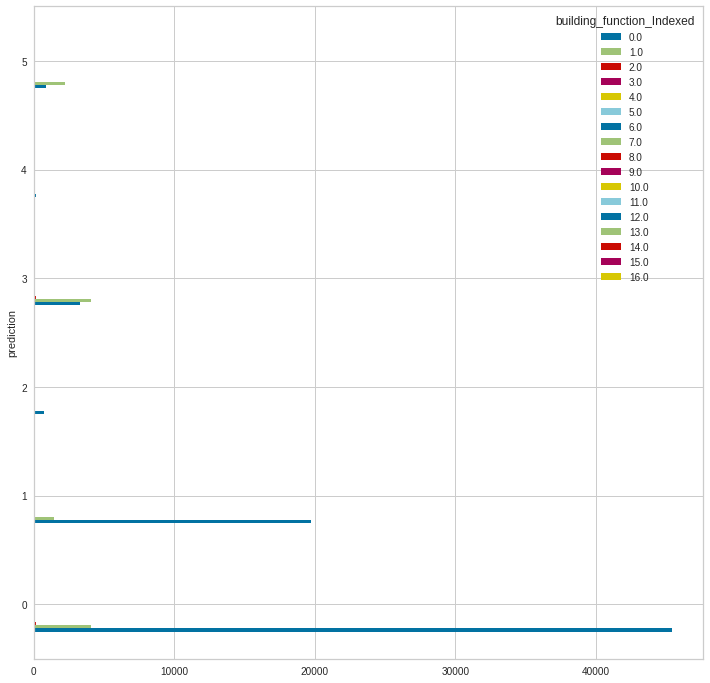

In [363]:
func_cluster_pivot.T.plot(kind='barh',figsize=(12,12))

Based on building_function attribute, the majority of cluster 0 and 1 belongs the 0-class of building function, while a small portion of them belongs to class 1. (class 0: Wohnhaus, class 1: Wohngebäude mit Gemeinbedarf). In addition, building_function 0 and 1 also accounts the most. 

In [364]:
muni_cluster_pivot = pd.pivot_table(predictions.select(['municipality_key_Indexed','prediction']).toPandas(),
               columns='prediction', index='municipality_key_Indexed', aggfunc=len)

In [365]:
muni_cluster_pivot

prediction,0,1,2,3,4,5
municipality_key_Indexed,,,,,,
0.0,46719.0,20620.0,790.0,13.0,150.0,NaN
1.0,2953.0,445.0,2.0,6.0,2.0,NaN
2.0,NaN,181.0,10.0,2805.0,2.0,NaN
3.0,NaN,2.0,NaN,1970.0,6.0,NaN
4.0,NaN,5.0,3.0,1314.0,1.0,404.0
5.0,NaN,NaN,NaN,1680.0,2.0,NaN
6.0,NaN,NaN,NaN,NaN,NaN,988.0
7.0,NaN,NaN,NaN,NaN,NaN,798.0
8.0,NaN,NaN,NaN,NaN,NaN,527.0


<AxesSubplot:ylabel='prediction'>

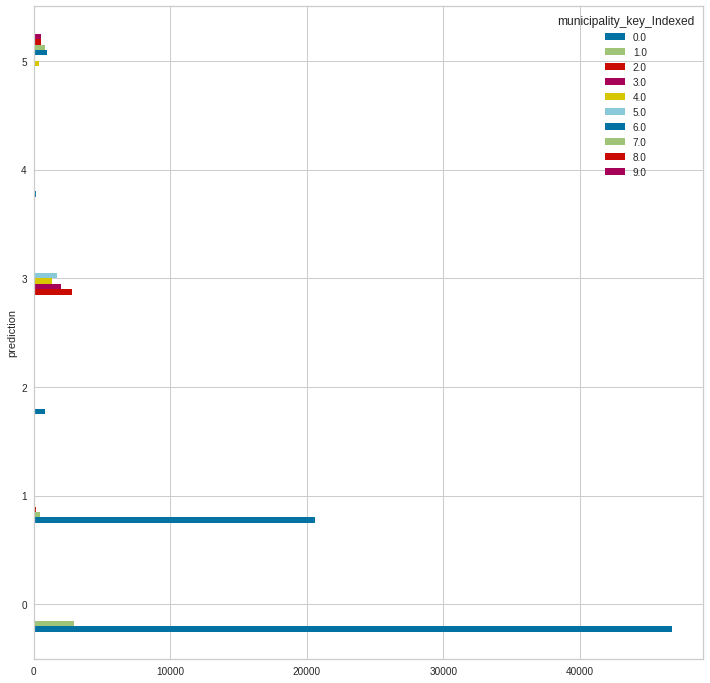

In [366]:
muni_cluster_pivot.T.plot(kind='barh',figsize=(12,12))

In [370]:
df_result = df_resi_final.select("features").rdd.map(lambda x: x[0].toArray().tolist()).toDF()
df_result.show(3)

+---+---+---+---+---+---+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+
| _1| _2| _3| _4| _5| _6|                _7|                _8|                 _9|               _10|               _11|                _12|               _13|
+---+---+---+---+---+---+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+
|1.0|0.0|0.0|0.0|0.0|1.0|0.5396564961130015|3.2784135854260925|0.14957166323337293|146.99312532155514|1534.3069695940103|0.06300135642503567| 3.580251951643275|
|0.0|0.0|1.0|0.0|0.0|1.0| 1.473663306871073|4.0980169817826155|                0.0|146.93842952732007|1534.1866621207844|0.07212939386161754| 2.784640406833658|
|0.0|0.0|0.0|0.0|0.0|1.0|0.8515094609970851|3.2784135854260925|                0.0|146.94597890291192|1534.1655564669788|0.09414407238513853|1.5912230896192332|
+---+---+---+---+---+---+---------

In [371]:
# Predict
df_result = df_result.withColumn('row_index', f.monotonically_increasing_id())
#data_result = data_result.withColumn('row_index', f.monotonically_increasing_id())
df_result = df_result.join(data_result, on=["row_index"]).sort("row_index").drop("row_index")

In [377]:
df_result.show(3)

+---+---+---+---+---+---+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+----------+
| _1| _2| _3| _4| _5| _6|                _7|                _8|                 _9|               _10|               _11|                _12|               _13|prediction|
+---+---+---+---+---+---+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+----------+
|1.0|0.0|0.0|0.0|0.0|1.0|0.5396564961130015|3.2784135854260925|0.14957166323337293|146.99312532155514|1534.3069695940103|0.06300135642503567| 3.580251951643275|         1|
|0.0|0.0|1.0|0.0|0.0|1.0| 1.473663306871073|4.0980169817826155|                0.0|146.93842952732007|1534.1866621207844|0.07212939386161754| 2.784640406833658|         1|
|0.0|0.0|0.0|0.0|0.0|1.0|0.8515094609970851|3.2784135854260925|                0.0|146.94597890291192|1534.1655564669788|0.09414407238513853

In [380]:
from pyspark.sql.functions import col,isnan, when, count

In [381]:
df_result_liv_par = df_result.select(col("_7").alias("living_space"), col("_12").alias("alkis_parcel_area"), "prediction")

In [384]:
df_result_liv_par.show(3)

+------------------+-------------------+----------+
|      living_space|  alkis_parcel_area|prediction|
+------------------+-------------------+----------+
|0.5396564961130015|0.06300135642503567|         1|
| 1.473663306871073|0.07212939386161754|         1|
|0.8515094609970851|0.09414407238513853|         1|
+------------------+-------------------+----------+
only showing top 3 rows



/home/vhdinh/.local/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


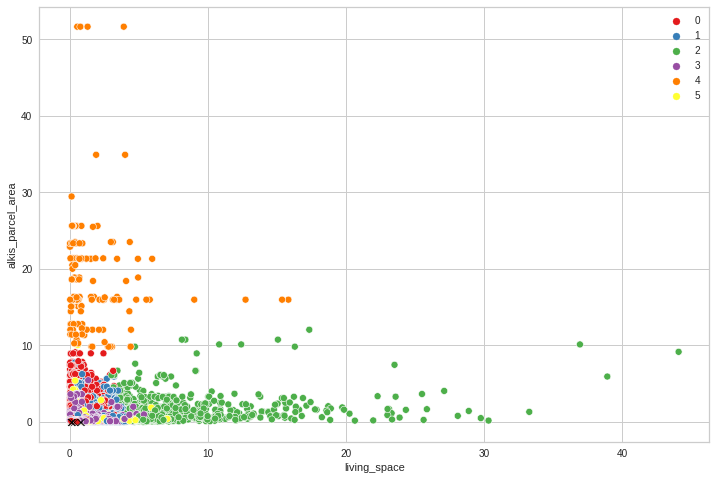

In [385]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(x="living_space", y="alkis_parcel_area", data =df_result_liv_par.toPandas(),
               hue="prediction",
               # size = "prediction",
               palette = "Set1")

#centers
sns.scatterplot(data=centers_df, x=0,y=1,color="black",marker="x")
plt.show()
fig.savefig('Cluster_6_liv_par.png')

In [390]:
df_resi_sub.toPandas()

,building_function,storeys_above_ground,family_home,living_space,calculated_storeys,garage_parking_lots,solar_area,longitude,latitude,alkis_parcel_area,municipality_key,dormer_number,converted_attic,building_function_indexed,storeys_above_ground_indexed,family_home_indexed,garage_parking_lots_indexed,municipality_key_indexed,converted_attic_indexed
0,Wohnhaus,0,Single,177.339996,4,0.0,0.686105,7.172823,50.686604,352.0,05314000,9.0,1,1.0,0.0,0.0,0.0,0.0,1.0
1,Wohngebäude mit Gemeinbedarf,0,Multi,484.269989,5,0.0,0.000000,7.170154,50.682630,403.0,05314000,7.0,1,0.0,0.0,1.0,0.0,0.0,1.0
2,Wohngebäude mit Gemeinbedarf,0,Single,279.820007,4,0.0,0.000000,7.170523,50.681933,526.0,05314000,4.0,1,0.0,0.0,0.0,0.0,0.0,1.0
3,Wohngebäude mit Gemeinbedarf,0,Single,308.579987,4,0.0,0.000000,7.170401,50.684632,195.0,05314000,4.0,1,0.0,0.0,0.0,0.0,0.0,1.0
4,Wohnhaus,0,Single,389.359985,4,0.0,0.000000,7.166636,50.681545,713.0,05314000,6.0,1,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82908,Wohnhaus,0,Single,245.500000,2,0.0,0.000000,7.087153,50.640187,989.0,05382072,7.0,1,1.0,0.0,0.0,0.0,3.0,1.0
82909,Wohnhaus,0,Single,31.780001,1,0.0,0.000000,7.018843,50.694029,744.0,05382004,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0
82910,Wohnhaus,0,Single,171.179993,2,0.0,0.000000,7.018146,50.727846,283.0,05382004,3.0,1,1.0,0.0,0.0,0.0,1.0,1.0
82911,Wohnhaus,0,Single,179.389999,3,0.0,0.000000,7.183978,50.706337,309.0,05382024,0.0,0,1.0,0.0,0.0,0.0,2.0,0.0


<AxesSubplot:xlabel='living_space', ylabel='alkis_parcel_area'>

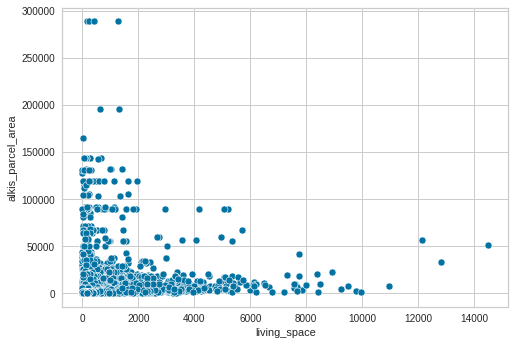

In [391]:
sns.scatterplot(x=df_resi_sub.toPandas()['living_space'], y=df_resi_sub.toPandas()['alkis_parcel_area'])